<a href="https://colab.research.google.com/github/Satria55/56/blob/main/BDPL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset : https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database

| No  | Nama                                | NIM         |
|-----|-------------------------------------|-------------|
| 1   | Satria Andika Putra    | 18.11.2423  |

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=e2666a6f2b8020a1ac8ec718981a5ddbdf73ea5db1964e515f4e05b37675fe1d
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


# **Import Library**

In [ ]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
from pyspark.sql.functions import sum, when
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import seaborn as sns

# **Load Dataset**

In [ ]:
spark = SparkSession.builder.appName('diabetes').getOrCreate()
df = spark.read.csv('/content/drive/MyDrive/BDPL/diabetes.csv', header = True, inferSchema = True)
df.printSchema()

root
 |-- Pregnancies: integer (nullable = true)
 |-- Glucose: integer (nullable = true)
 |-- BloodPressure: integer (nullable = true)
 |-- SkinThickness: integer (nullable = true)
 |-- Insulin: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- DiabetesPedigreeFunction: double (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Outcome: integer (nullable = true)



In [ ]:
df.show()

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|      1|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|      0|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|      1|
|          1|     89|           66|           23|     94|28.1|                   0.167| 21|      0|
|          0|    137|           40|           35|    168|43.1|                   2.288| 33|      1|
|          5|    116|           74|            0|      0|25.6|                   0.201| 30|      0|
|          3|     78|           50|           32|     88|31.0|                   0.248| 26|      1|


# **Preprocessing**

In [ ]:
new_columns = ["Pregnancies", "Glucose", "Blood_Pressure", "Skin_Thickness", "Insulin", "BMI", "Diabetes_Pedigree_Function", "Age", "Outcome"]
df = df.toDF(*new_columns)
df.show()

+-----------+-------+--------------+--------------+-------+----+--------------------------+---+-------+
|Pregnancies|Glucose|Blood_Pressure|Skin_Thickness|Insulin| BMI|Diabetes_Pedigree_Function|Age|Outcome|
+-----------+-------+--------------+--------------+-------+----+--------------------------+---+-------+
|          6|    148|            72|            35|      0|33.6|                     0.627| 50|      1|
|          1|     85|            66|            29|      0|26.6|                     0.351| 31|      0|
|          8|    183|            64|             0|      0|23.3|                     0.672| 32|      1|
|          1|     89|            66|            23|     94|28.1|                     0.167| 21|      0|
|          0|    137|            40|            35|    168|43.1|                     2.288| 33|      1|
|          5|    116|            74|             0|      0|25.6|                     0.201| 30|      0|
|          3|     78|            50|            32|     88|31.0|

In [ ]:
pd.DataFrame(df.take(10), columns=df.columns).transpose()

,0,1,2,3,4,5,6,7,8,9
Pregnancies,6.000,1.000,8.000,1.000,0.000,5.000,3.000,10.000,2.000,8.000
Glucose,148.000,85.000,183.000,89.000,137.000,116.000,78.000,115.000,197.000,125.000
Blood_Pressure,72.000,66.000,64.000,66.000,40.000,74.000,50.000,0.000,70.000,96.000
Skin_Thickness,35.000,29.000,0.000,23.000,35.000,0.000,32.000,0.000,45.000,0.000
Insulin,0.000,0.000,0.000,94.000,168.000,0.000,88.000,0.000,543.000,0.000
BMI,33.600,26.600,23.300,28.100,43.100,25.600,31.000,35.300,30.500,0.000
Diabetes_Pedigree_Function,0.627,0.351,0.672,0.167,2.288,0.201,0.248,0.134,0.158,0.232
Age,50.000,31.000,32.000,21.000,33.000,30.000,26.000,29.000,53.000,54.000
Outcome,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,1.000


Mengambil kolom yang memiliki fitur numerik

In [ ]:
numeric_features = [t[0] for t in df.dtypes if t[1]]
numeric_summary = df.select(numeric_features).summary()
numeric_summary.show(truncate=False)

+-------+------------------+-----------------+------------------+------------------+------------------+------------------+--------------------------+------------------+------------------+
|summary|Pregnancies       |Glucose          |Blood_Pressure    |Skin_Thickness    |Insulin           |BMI               |Diabetes_Pedigree_Function|Age               |Outcome           |
+-------+------------------+-----------------+------------------+------------------+------------------+------------------+--------------------------+------------------+------------------+
|count  |768               |768              |768               |768               |768               |768               |768                       |768               |768               |
|mean   |3.8450520833333335|120.89453125     |69.10546875       |20.536458333333332|79.79947916666667 |31.992578124999977|0.4718763020833327        |33.240885416666664|0.3489583333333333|
|stddev |3.36957806269887  |31.97261819513622|19.35580717064

Menampilkan Missing Value

In [ ]:
missing_values = df.select([col(c).alias(c) for c in df.columns]).na.fill(0).agg(*[sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])

# Menampilkan hasil
print("Jumlah nilai-nilai yang hilang pada setiap kolom:")
missing_values.show(truncate=False)

Jumlah nilai-nilai yang hilang pada setiap kolom:
+-----------+-------+--------------+--------------+-------+---+--------------------------+---+-------+
|Pregnancies|Glucose|Blood_Pressure|Skin_Thickness|Insulin|BMI|Diabetes_Pedigree_Function|Age|Outcome|
+-----------+-------+--------------+--------------+-------+---+--------------------------+---+-------+
|0          |0      |0             |0             |0      |0  |0                         |0  |0      |
+-----------+-------+--------------+--------------+-------+---+--------------------------+---+-------+



In [ ]:
diabetes_sum = df.groupBy('Outcome').count()

# Menampilkan hasil
print("Jumlah kemunculan setiap nilai pada kolom 'Outcome':")
diabetes_sum.show()

Jumlah kemunculan setiap nilai pada kolom 'Outcome':
+-------+-----+
|Outcome|count|
+-------+-----+
|      1|  268|
|      0|  500|
+-------+-----+



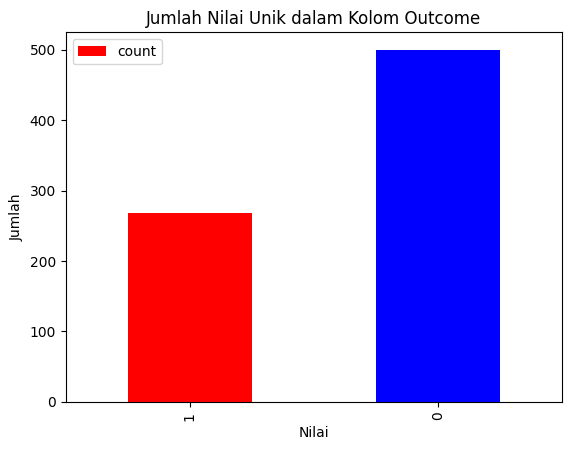

In [ ]:
diabetes_counts_pd = diabetes_sum.toPandas()

# Plot bar chart
diabetes_counts_pd.plot(kind='bar', x='Outcome', y='count', color=['red', 'blue'])
plt.title('Jumlah Nilai Unik dalam Kolom Outcome')
plt.xlabel('Nilai')
plt.ylabel('Jumlah')
plt.show()

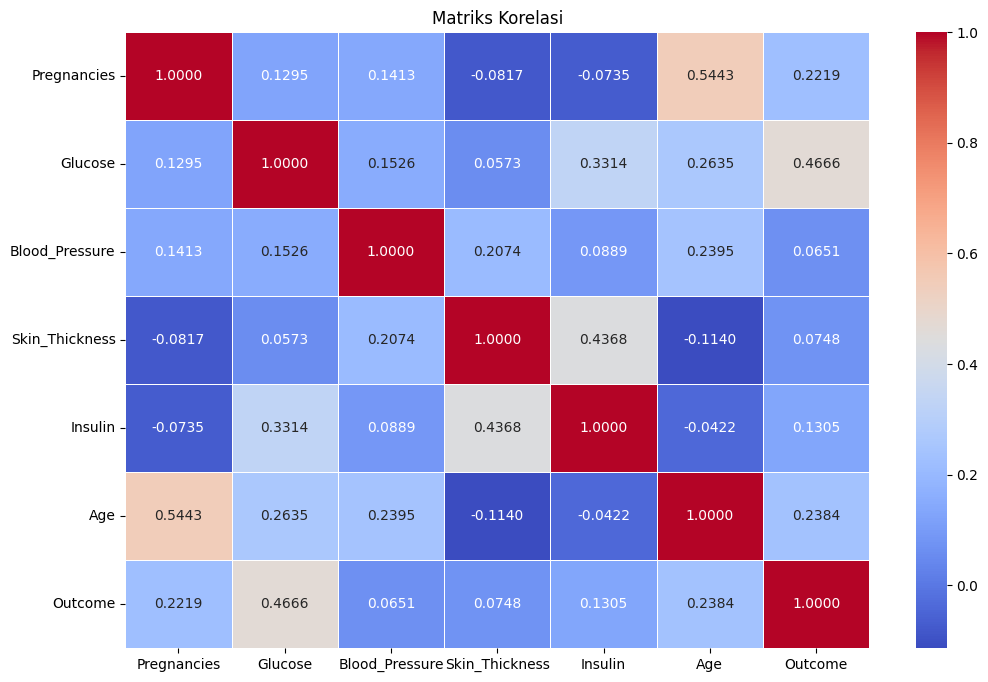

In [ ]:
integer_columns = [col_name for col_name, col_type in df.dtypes if col_type == 'int']


vector_assembler = VectorAssembler(inputCols=integer_columns, outputCol="features")
df_assembled = vector_assembler.transform(df).select("features")


matrix = Correlation.corr(df_assembled, "features").head()
correlation_matrix = matrix[0].toArray()


column_names = df_assembled.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]


plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".4f", linewidths=.5,
            xticklabels=[col["name"] for col in column_names], yticklabels=[col["name"] for col in column_names])
plt.title("Matriks Korelasi")
plt.show()

# Logistic Regresion

In [ ]:
# Nama kolom-kolom
feature_columns = [col for col in df.columns if col != 'Outcome']

assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
dfreg = assembler.transform(df).select('features', 'Outcome')

# Tampilkan hasil
dfreg.show(truncate=False)

+-------------------------------------------+-------+
|features                                   |Outcome|
+-------------------------------------------+-------+
|[6.0,148.0,72.0,35.0,0.0,33.6,0.627,50.0]  |1      |
|[1.0,85.0,66.0,29.0,0.0,26.6,0.351,31.0]   |0      |
|[8.0,183.0,64.0,0.0,0.0,23.3,0.672,32.0]   |1      |
|[1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0]  |0      |
|[0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0]|1      |
|[5.0,116.0,74.0,0.0,0.0,25.6,0.201,30.0]   |0      |
|[3.0,78.0,50.0,32.0,88.0,31.0,0.248,26.0]  |1      |
|[10.0,115.0,0.0,0.0,0.0,35.3,0.134,29.0]   |0      |
|[2.0,197.0,70.0,45.0,543.0,30.5,0.158,53.0]|1      |
|[8.0,125.0,96.0,0.0,0.0,0.0,0.232,54.0]    |1      |
|[4.0,110.0,92.0,0.0,0.0,37.6,0.191,30.0]   |0      |
|[10.0,168.0,74.0,0.0,0.0,38.0,0.537,34.0]  |1      |
|[10.0,139.0,80.0,0.0,0.0,27.1,1.441,57.0]  |0      |
|[1.0,189.0,60.0,23.0,846.0,30.1,0.398,59.0]|1      |
|[5.0,166.0,72.0,19.0,175.0,25.8,0.587,51.0]|1      |
|[7.0,100.0,0.0,0.0,0.0,30.0

In [ ]:
train, test = dfreg.randomSplit([0.8, 0.2], seed = 5)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 629
Test Dataset Count: 139


In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression

df = LogisticRegression(featuresCol = 'features', labelCol = 'Outcome', maxIter=3)
dfModel = df.fit(train)

predictions = dfModel.transform(test)

# Inisialisasi evaluator akurasi
evaluator_accuracy = MulticlassClassificationEvaluator(
    labelCol='Outcome',
    predictionCol='prediction',
    metricName='accuracy'
)

# Evaluasi akurasi
accuracy = evaluator_accuracy.evaluate(predictions)
print(f'Test Accuracy: {accuracy:.2%}')

# Inisialisasi evaluator F1-score
evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol='Outcome',
    predictionCol='prediction',
    metricName='f1'
)

# Evaluasi F1-score
f1_score = evaluator_f1.evaluate(predictions)
print(f'Test F1-Score: {f1_score:.2%}')

# Filter prediksi yang salah
wrong_predictions = predictions.filter(col('Outcome') != col('prediction'))

# Tampilkan hasil
wrong_predictions.select('features', 'Outcome', 'rawPrediction', 'prediction', 'probability').show(10)

# Hitung jumlah prediksi yang salah
count_wrong_predictions = wrong_predictions.count()
print(f'Jumlah prediksi yang salah: {count_wrong_predictions}')

Test Accuracy: 69.78%
Test F1-Score: 69.34%
+--------------------+-------+--------------------+----------+--------------------+
|            features|Outcome|       rawPrediction|prediction|         probability|
+--------------------+-------+--------------------+----------+--------------------+
|[0.0,95.0,85.0,25...|      1|[2.21535827037886...|       0.0|[0.90162023563321...|
|[0.0,113.0,76.0,0...|      1|[1.87068934677453...|       0.0|[0.86653802048387...|
|[0.0,118.0,84.0,4...|      1|[0.29373578354340...|       0.0|[0.57291046761109...|
|[0.0,123.0,72.0,0...|      1|[0.73355559711053...|       0.0|[0.67558503841898...|
|[0.0,165.0,90.0,3...|      0|[-1.4394271788163...|       1.0|[0.19163406887639...|
|[1.0,102.0,74.0,0...|      1|[1.16021654278468...|       0.0|[0.76137205956888...|
|[1.0,117.0,88.0,2...|      1|[1.28241265968643...|       0.0|[0.78286018460507...|
|[1.0,120.0,80.0,4...|      0|[-0.0616612723141...|       1.0|[0.48458956429626...|
|[1.0,164.0,82.0,4...|      0|[-

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


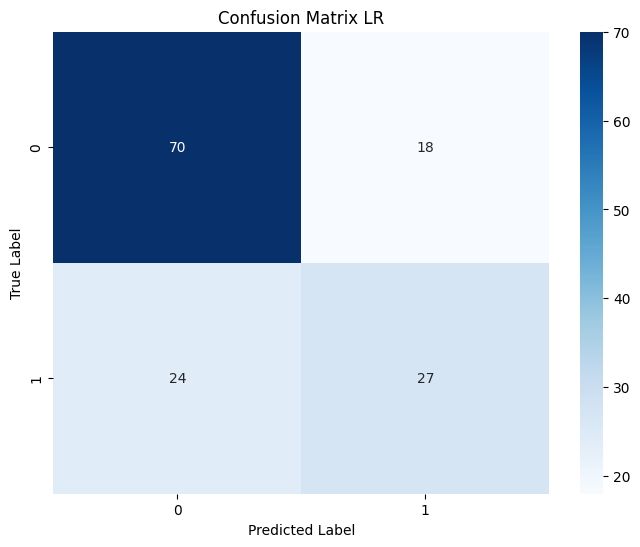

In [ ]:
from pyspark.mllib.evaluation import MulticlassMetrics

prediction_and_labels = predictions.select('prediction', 'Outcome').rdd.map(lambda row: (float(row['prediction']), float(row['Outcome'])))

# Inisialisasi MulticlassMetrics
metrics = MulticlassMetrics(prediction_and_labels)

# Ambil confusion matrix sebagai array
confusion_matrix = metrics.confusionMatrix().toArray()

# Konversi confusion matrix ke tipe data integer
confusion_matrix = confusion_matrix.astype(int)

# Tampilkan confusion matrix menggunakan seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Confusion Matrix LR')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# Decision Tree Classifier

In [ ]:
from pyspark.sql import SparkSession

# Anggaplah Anda memiliki file CSV dengan kolom-kolom yang dibutuhkan, gantilah 'file_anda.csv' dengan path file yang sesuai
lcprepose = spark.read.csv('/content/drive/MyDrive/BDPL/diabetes.csv', header=True, inferSchema=True)
# Sekarang Anda dapat melanjutkan dengan bagian kode selanjutnya
kolom_fitur = [kolom for kolom in lcprepose.columns if kolom != 'Outcome']

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Assuming lcprepose is your DataFrame with columns including 'Outcome'
feature_columns = [col for col in lcprepose.columns if col != 'Outcome']

# Using VectorAssembler to combine features into a single vector column
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')

# Initialize DecisionTreeClassifier
dt = DecisionTreeClassifier(labelCol='Outcome', featuresCol='features')

# Create a pipeline with the assembler and DecisionTreeClassifier
pipeline = Pipeline(stages=[assembler, dt])

# Split the data into train and test sets
train2, test_data = lcprepose.randomSplit([0.8, 0.2], seed=5)

# Train the model using the train data
model = pipeline.fit(train2)


# Make predictions on the test data
predictions = model.transform(test_data)

# Evaluate the model using MulticlassClassificationEvaluator for accuracy
evaluator_accuracy = MulticlassClassificationEvaluator(
    labelCol='Outcome',
    predictionCol='prediction',
    metricName='accuracy'
)

# Measure accuracy
accuracy = evaluator_accuracy.evaluate(predictions)
print(f'Test Accuracy: {accuracy:.2%}')

# Evaluate the model using F1-Score
evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol='Outcome',
    predictionCol='prediction',
    metricName='f1'
)

# Measure F1-Score
f1_score = evaluator_f1.evaluate(predictions)
print(f'Test F1-Score: {f1_score:.2%}')

# Display prediction results
predictions.select('features', 'Outcome', 'rawPrediction', 'prediction', 'probability').show(10)


Test Accuracy: 66.91%
Test F1-Score: 64.46%
+--------------------+-------+-------------+----------+--------------------+
|            features|Outcome|rawPrediction|prediction|         probability|
+--------------------+-------+-------------+----------+--------------------+
|[0.0,86.0,68.0,32...|      0| [100.0,12.0]|       0.0|[0.89285714285714...|
|[0.0,101.0,76.0,0...|      0| [100.0,12.0]|       0.0|[0.89285714285714...|
|[0.0,102.0,86.0,1...|      0|  [123.0,2.0]|       0.0|       [0.984,0.016]|
|[0.0,109.0,88.0,3...|      1|   [9.0,25.0]|       1.0|[0.26470588235294...|
|(8,[1,5,6,7],[117...|      0|   [9.0,25.0]|       1.0|[0.26470588235294...|
|[0.0,119.0,64.0,1...|      0| [100.0,12.0]|       0.0|[0.89285714285714...|
|[0.0,119.0,66.0,2...|      0| [100.0,12.0]|       0.0|[0.89285714285714...|
|[0.0,123.0,72.0,0...|      1|  [47.0,28.0]|       0.0|[0.62666666666666...|
|[0.0,126.0,84.0,2...|      0| [100.0,12.0]|       0.0|[0.89285714285714...|
|[0.0,126.0,86.0,2...|      0|  

In [ ]:
# Assuming you have already defined and trained your model using the 'pipeline' and 'train2' data
model = pipeline.fit(train2)

# Make predictions on the test data
predictionsDTC = model.transform(train2)

# Cast 'Outcome' column to DoubleType
predictionsDTC = predictionsDTC.withColumn('Outcome', col('Outcome').cast('double'))

# Continue with the rest of your code for evaluation and visualization


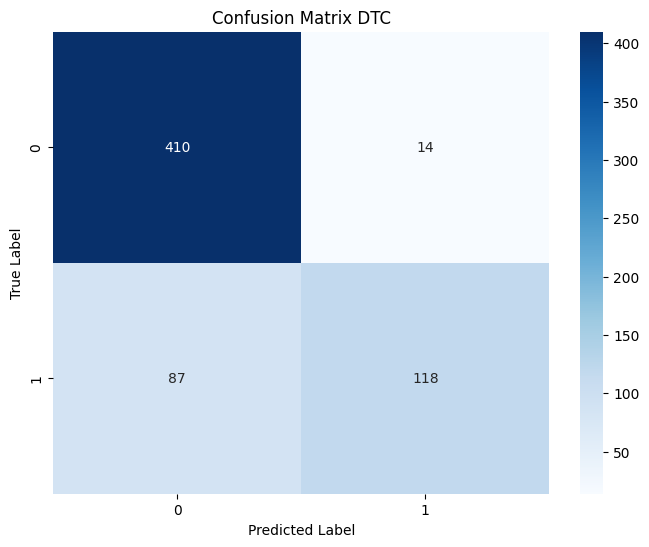

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.functions import col

# Cast 'Outcome' column to DoubleType
predictionsDTC = predictionsDTC.withColumn('Outcome', col('Outcome').cast('double'))

# Mengambil kolom label dan prediksi sebagai RDD untuk MulticlassMetrics
predictionAndLabelsDTC = predictionsDTC.select('prediction', 'Outcome').rdd

# Inisialisasi MulticlassMetrics
metricsDTC = MulticlassMetrics(predictionAndLabelsDTC)

# Mendapatkan matriks konfusi
confusion_matrixDTC = metricsDTC.confusionMatrix().toArray()

# Konversi matriks konfusi menjadi DataFrame
confusion_matrix_DTC = pd.DataFrame(confusion_matrixDTC, columns=[str(i) for i in range(confusion_matrixDTC.shape[1])])

# Plot confusion matrix menggunakan seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_DTC, annot=True, fmt="g", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Confusion Matrix DTC')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Random Forest Classifier

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
# Inisialisasi model Random Forest
rf = RandomForestClassifier(labelCol="Outcome", featuresCol="features", numTrees=10)

# Pipeline
pipeline_rf = Pipeline(stages=[assembler, rf])

# Train model
model_rf = pipeline_rf.fit(train2)

# Make predictions
predictionRFC = model_rf.transform(train2)

# Evaluate accuracy
evaluator_accuracy_rf = MulticlassClassificationEvaluator(
    labelCol='Outcome',
    predictionCol='prediction',
    metricName='accuracy'
)

# Evaluate F1-Score
evaluator_f1_rf = MulticlassClassificationEvaluator(
    labelCol='Outcome',
    predictionCol='prediction',
    metricName='f1'
)

# Accuracy
accuracy_rf = evaluator_accuracy_rf.evaluate(predictionRFC)
print(f'Test Accuracy: {accuracy_rf:.2%}')

# F1-Score
f1_score_rf = evaluator_f1_rf.evaluate(predictionRFC)
print(f'Test F1-Score: {f1_score_rf:.2%}')

predictionRFC.select('features', 'Outcome', 'rawPrediction', 'prediction', 'probability').show(10)

Test Accuracy: 84.58%
Test F1-Score: 84.16%
+--------------------+-------+--------------------+----------+--------------------+
|            features|Outcome|       rawPrediction|prediction|         probability|
+--------------------+-------+--------------------+----------+--------------------+
|[0.0,57.0,60.0,0....|      0|[8.98875521820426...|       0.0|[0.89887552182042...|
|[0.0,67.0,76.0,0....|      0|[7.01160715935501...|       0.0|[0.70116071593550...|
|(8,[1,5,6,7],[73....|      0|[9.68137485887884...|       0.0|[0.96813748588788...|
|[0.0,74.0,52.0,10...|      0|[9.43757272591602...|       0.0|[0.94375727259160...|
|[0.0,78.0,88.0,29...|      0|[8.97520044715887...|       0.0|[0.89752004471588...|
|[0.0,84.0,64.0,22...|      0|[8.97520044715887...|       0.0|[0.89752004471588...|
|[0.0,84.0,82.0,31...|      0|[8.88429135624978...|       0.0|[0.88842913562497...|
|[0.0,91.0,68.0,32...|      0|[8.91333168781259...|       0.0|[0.89133316878125...|
|[0.0,91.0,80.0,0....|      0|[8

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


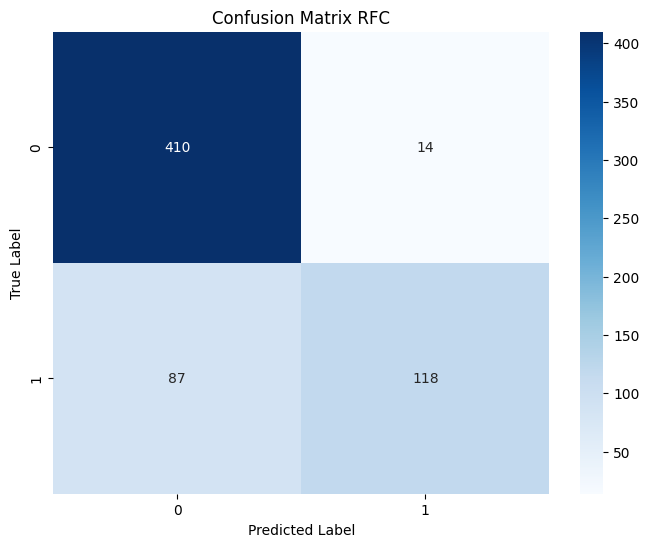

In [ ]:
# Cast 'Outcome' column to DoubleType
predictionsRFC = predictionRFC.withColumn('Outcome', col('Outcome').cast('double'))

# Mengambil kolom label dan prediksi sebagai RDD untuk MulticlassMetrics
predictionAndLabelsRFC = predictionsRFC.select('prediction', 'Outcome').rdd

# Inisialisasi MulticlassMetrics
metricsRFC = MulticlassMetrics(predictionAndLabelsDTC)

# Mendapatkan matriks konfusi
confusion_matrixRFC = metricsRFC.confusionMatrix().toArray()

# Konversi matriks konfusi menjadi DataFrame
confusion_matrix_RFC = pd.DataFrame(confusion_matrixRFC, columns=[str(i) for i in range(confusion_matrixRFC.shape[1])])

# Plot confusion matrix menggunakan seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_RFC, annot=True, fmt="g", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Confusion Matrix RFC')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



# Gradient-Boosted Trees

In [ ]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml import Pipeline

# Inisialisasi GBTClassifier
gbt = GBTClassifier(labelCol="Outcome", featuresCol="features", maxIter=10)

# Pipeline
pipeline_gbt = Pipeline(stages=[assembler, gbt])

# Train model
model_gbt = pipeline_gbt.fit(train2)

# Melakukan prediksi pada test data
prediction_gbt = model_gbt.transform(train2)

# Evaluasi model menggunakan MulticlassClassificationEvaluator
evaluator_accuracy_gbt = MulticlassClassificationEvaluator(
    labelCol='Outcome',
    predictionCol='prediction',
    metricName='accuracy'
)

# Evaluasi F1-Score
evaluator_f1_gbt = MulticlassClassificationEvaluator(
    labelCol='Outcome',
    predictionCol='prediction',
    metricName='f1'
)

# Accuracy
accuracy_gbt = evaluator_accuracy_gbt.evaluate(prediction_gbt)
print(f'Test Accuracy: {accuracy_gbt:.2%}')

# F1-Score
f1_score_gbt = evaluator_f1_gbt.evaluate(prediction_gbt)
print(f'Test F1-Score: {f1_score_gbt:.2%}')

# Menampilkan hasil prediksi
prediction_gbt.select('features', 'Outcome', 'rawPrediction', 'prediction', 'probability').show(10)

Test Accuracy: 92.37%
Test F1-Score: 92.30%
+--------------------+-------+--------------------+----------+--------------------+
|            features|Outcome|       rawPrediction|prediction|         probability|
+--------------------+-------+--------------------+----------+--------------------+
|[0.0,57.0,60.0,0....|      0|[0.92932283369801...|       0.0|[0.86513901144665...|
|[0.0,67.0,76.0,0....|      0|[0.86519959694796...|       0.0|[0.84946347440696...|
|(8,[1,5,6,7],[73....|      0|[1.22823109672026...|       0.0|[0.92103273604975...|
|[0.0,74.0,52.0,10...|      0|[1.24049081202475...|       0.0|[0.92279775980775...|
|[0.0,78.0,88.0,29...|      0|[1.08122377491908...|       0.0|[0.89682623778575...|
|[0.0,84.0,64.0,22...|      0|[1.04655711674906...|       0.0|[0.89023211513276...|
|[0.0,84.0,82.0,31...|      0|[1.06248925243910...|       0.0|[0.89330735738617...|
|[0.0,91.0,68.0,32...|      0|[0.73730676442643...|       0.0|[0.81375760711616...|
|[0.0,91.0,80.0,0....|      0|[0

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


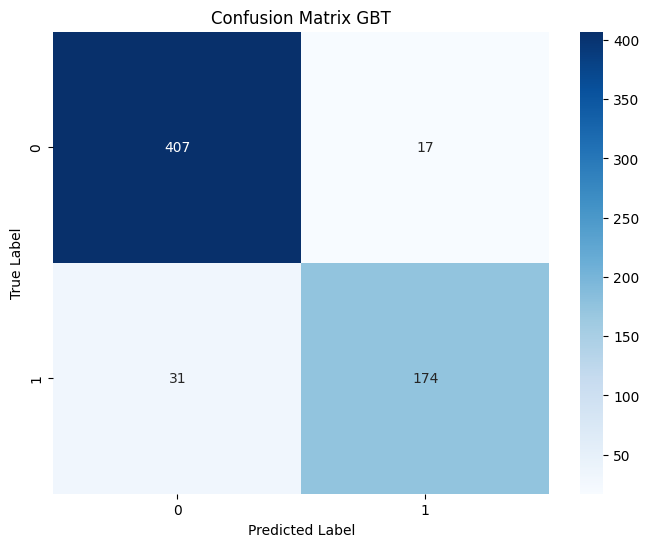

In [ ]:
# Cast 'LUNG_CANCER' column to DoubleType
predictionsGBT = prediction_gbt.withColumn('Outcome', col('Outcome').cast('double'))

# Mengambil kolom label dan prediksi sebagai RDD untuk MulticlassMetrics
predictionAndLabelsGBT = predictionsGBT.select('prediction', 'Outcome').rdd

# Inisialisasi MulticlassMetrics
metricsGBT = MulticlassMetrics(predictionAndLabelsGBT)

# Mendapatkan matriks konfusi
confusion_matrixGBT = metricsGBT.confusionMatrix().toArray()

# Konversi matriks konfusi menjadi DataFrame
confusion_matrix_GBT = pd.DataFrame(confusion_matrixGBT, columns=[str(i) for i in range(confusion_matrixGBT.shape[1])])

# Plot confusion matrix menggunakan seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_GBT, annot=True, fmt="g", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Confusion Matrix GBT')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
plt.show()


## Hypertune DTC dan GBT

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [4, 12, 24])  # Variasi kedalaman maksimum pohon
             .addGrid(dt.impurity, ['gini', 'entropy'])  # Variasi jenis impurity
             .addGrid(dt.minInstancesPerNode, [2, 4, 6, 8])  # Variasi minimum instances per node
             #.addGrid(dt.maxBins, [5, 10, 15])  # Variasi jumlah bins maksimum
             .build())

# Inisialisasi evaluator F1-score
evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol='Outcome',
    predictionCol='prediction',
    metricName='f1'
)

# CrossValidator
cvdt = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid, evaluator=evaluator_f1, numFolds=5)

# Fit the model
cvModeldt = cvdt.fit(train2)

# Make predictions on test data
predictionsDTC_tuned = cvModeldt.transform(train2)

# Evaluate the model
f1_score_tuned = evaluator_f1.evaluate(predictionsDTC_tuned)
print(f'Tuned Test F1-Score: {f1_score_tuned:.2%}')

# Best hyperparameters
best_params = cvModeldt.bestModel.stages[-1].extractParamMap()
print("Best Hyperparameters:")
for param, value in best_params.items():
    print(f"{param.name}: {value}")

Tuned Test F1-Score: 87.15%
Best Hyperparameters:
cacheNodeIds: False
checkpointInterval: 10
featuresCol: features
impurity: gini
labelCol: Outcome
leafCol: 
maxBins: 32
maxDepth: 12
maxMemoryInMB: 256
minInfoGain: 0.0
minInstancesPerNode: 8
minWeightFractionPerNode: 0.0
predictionCol: prediction
probabilityCol: probability
rawPredictionCol: rawPrediction
seed: 6029203428829696788


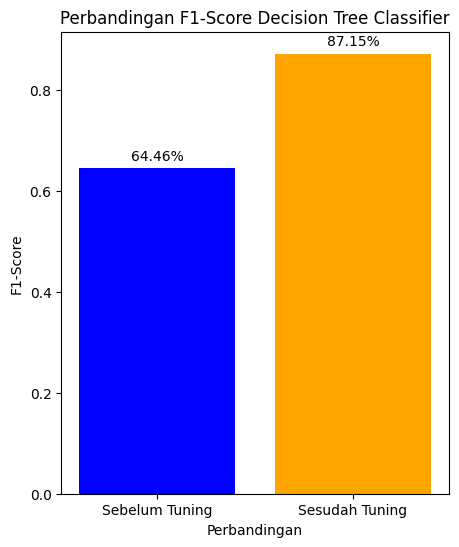

In [ ]:
f1_score_before_tuning_DTC = [f1_score]  # Gantilah dengan nilai F1-Score sebelum tuning untuk setiap model

# F1-Score setelah tuning
f1_score_after_tuning_DTC = [f1_score_tuned]  # Gantilah dengan nilai F1-Score setelah tuning untuk setiap model

# Nama model atau metode
model_name_DTC = ['Sebelum Tuning', 'Sesudah Tuning']  # Gantilah dengan nama model atau metode yang sesuai

# Plotting
plt.figure(figsize=(5, 6))
plt.bar(model_name_DTC, [max(f1_score_before_tuning_DTC), max(f1_score_after_tuning_DTC)], color=['blue', 'orange'])

# Menambahkan label dan judul
plt.xlabel('Perbandingan')
plt.ylabel('F1-Score')
plt.title('Perbandingan F1-Score Decision Tree Classifier')

# Menampilkan nilai F1-Score di atas batang
for i, value in enumerate([max(f1_score_before_tuning_DTC), max(f1_score_after_tuning_DTC)]):
    plt.text(i, value + 0.01, f'{value:.2%}', ha='center', va='bottom')

# Menampilkan plot
plt.show()

In [ ]:
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [5, 10, 15])
             .addGrid(gbt.maxBins, [32, 64, 128])
             .addGrid(gbt.stepSize, [0.1, 0.01])
             .build())

# Inisialisasi evaluator F1-score
crossval = CrossValidator(estimator=pipeline_gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator_accuracy_gbt,
                          numFolds=3)
# CrossValidator
cvModel = crossval.fit(train2)

best_model_gbt = cvModel.bestModel

# Make predictions on test data
prediction_best_gbt = best_model_gbt.transform(train2)

accuracy_best_gbt = evaluator_accuracy_gbt.evaluate(prediction_best_gbt)
f1_score_best_gbt = evaluator_f1_gbt.evaluate(prediction_best_gbt)

# Print the results
print(f'Best Model Test Accuracy: {accuracy_best_gbt:.2%}')
print(f'Best Model Test F1-Score: {f1_score_best_gbt:.2%}')

# Display the best model's parameters
print(f'Best Model Parameters: {best_model_gbt.stages[-1].extractParamMap()}')

Best Model Test Accuracy: 93.80%
Best Model Test F1-Score: 93.71%
Best Model Parameters: {Param(parent='GBTClassifier_d950d8f4328f', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False, Param(parent='GBTClassifier_d950d8f4328f', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10, Param(parent='GBTClassifier_d950d8f4328f', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'a

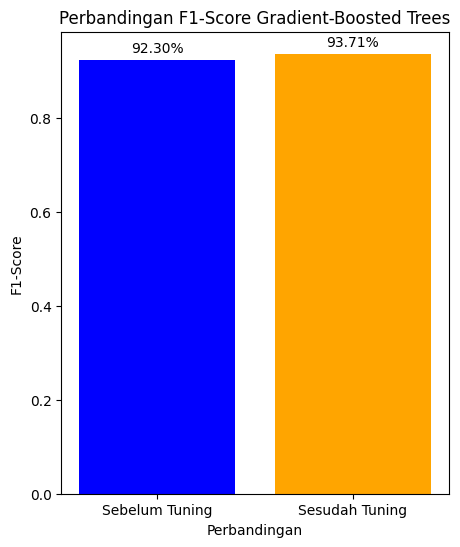

In [ ]:
import matplotlib.pyplot as plt

# F1-Score sebelum tuning
f1_score_before_tuning_GBT = [f1_score_gbt]

# F1-Score setelah tuning
f1_score_after_tuning_GBT = [f1_score_best_gbt]

# Nama model atau metode
model_name_GBT = ['Sebelum Tuning', 'Sesudah Tuning']

# Plotting
plt.figure(figsize=(5, 6))
plt.bar(model_name_GBT, [max(f1_score_before_tuning_GBT), max(f1_score_after_tuning_GBT)], color=['blue', 'orange'])

# Menambahkan label dan judul
plt.xlabel('Perbandingan')
plt.ylabel('F1-Score')
plt.title('Perbandingan F1-Score Gradient-Boosted Trees')

# Menampilkan nilai F1-Score di atas batang
for i, value in enumerate([max(f1_score_before_tuning_GBT), max(f1_score_after_tuning_GBT)]):
    plt.text(i, value + 0.01, f'{value:.2%}', ha='center', va='bottom')

# Menampilkan plot
plt.show()


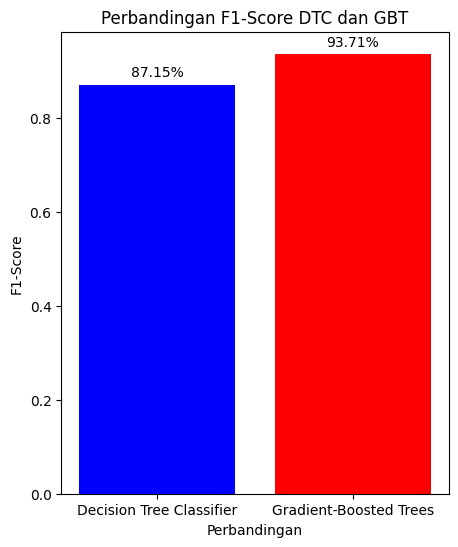

In [ ]:
# Nama model atau metode
model_name_compare = ['Decision Tree Classifier', 'Gradient-Boosted Trees']

# Plotting
plt.figure(figsize=(5, 6))
plt.bar(model_name_compare, [max(f1_score_after_tuning_DTC), max(f1_score_after_tuning_GBT)], color=['blue', 'red'])

# Menambahkan label dan judul
plt.xlabel('Perbandingan')
plt.ylabel('F1-Score')
plt.title('Perbandingan F1-Score DTC dan GBT')

# Menampilkan nilai F1-Score di atas batang
for i, value in enumerate([max(f1_score_after_tuning_DTC), max(f1_score_after_tuning_GBT)]):
    plt.text(i, value + 0.01, f'{value:.2%}', ha='center', va='bottom')

# Menampilkan plot
plt.show()


# Model Terbaik

Gradient-Boosted Trees

In [ ]:
best_model_gbt = cvModel.bestModel
# Ambil stage terakhir dari model (GBTClassifier)
best_gbt_model = best_model_gbt.stages[-1]
# Dapatkan model trees dari GBTClassifier
trees = best_gbt_model.trees
# Tampilkan model trees
for idx, tree in enumerate(trees):
    print(f"Tree {idx + 1}:\n{tree.toDebugString}\n{'='*40}")

Tree 1:
DecisionTreeRegressionModel: uid=dtr_31fc590447a0, depth=5, numNodes=53, numFeatures=8
  If (feature 1 <= 127.5)
   If (feature 7 <= 28.5)
    If (feature 5 <= 45.349999999999994)
     If (feature 5 <= 30.95)
      If (feature 6 <= 0.6755)
       Predict: -1.0
      Else (feature 6 > 0.6755)
       Predict: -0.8666666666666667
     Else (feature 5 > 30.95)
      If (feature 2 <= 12.0)
       Predict: 1.0
      Else (feature 2 > 12.0)
       Predict: -0.7938144329896907
    Else (feature 5 > 45.349999999999994)
     If (feature 1 <= 115.5)
      Predict: 1.0
     Else (feature 1 > 115.5)
      Predict: -1.0
   Else (feature 7 > 28.5)
    If (feature 4 <= 141.0)
     If (feature 1 <= 100.5)
      If (feature 6 <= 1.1564999999999999)
       Predict: -0.8620689655172413
      Else (feature 6 > 1.1564999999999999)
       Predict: 1.0
     Else (feature 1 > 100.5)
      If (feature 5 <= 26.25)
       Predict: -0.8888888888888888
      Else (feature 5 > 26.25)
       Predict: -0.13513

In [ ]:
from pyspark.sql import Row

# Buat data uji (ganti nilainya sesuai keinginan Anda)
test_data = Row(
    Pregnancies=3,
    Glucose=105,
    BloodPressure=86,
    SkinThickness=35,
    Insulin=0,
    BMI=38,
    DiabetesPedigreeFunction=0.523,
    Age=36
)

# Konversi data menjadi DataFrame
test_df = spark.createDataFrame([test_data])

# Split data into training and test sets
# Split data into training and test sets
train_2, test_gbt = train2.randomSplit([0.8, 0.2], seed=5)

# Gunakan model GBT yang telah di-tune untuk membuat prediksi
predictions = cvModel_gbt.transform(test_gbt)

# Agregasi hasil prediksi
aggregate_result = predictions.groupBy("prediction").count()

# Tampilkan hasil prediksi secara agregat
aggregate_result.show()

# Ambil hasil prediksi mayoritas
majority_prediction = aggregate_result.orderBy("count", ascending=False).first()["prediction"]

# Interpretasikan hasil prediksi mayoritas
if majority_prediction == 1.0:
    print("Prediksi: Terkena Diabetes")
else:
    print("Prediksi: Tidak Terkena Diabetes")


+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|   72|
|       1.0|   38|
+----------+-----+

Prediksi: Tidak Terkena Diabetes


**Hasil Output:**

Hasil output yang Anda sampaikan menunjukkan bahwa model GBT memberikan prediksi mayoritas 0.0 (Tidak Terkena Diabetes) dengan jumlah 86,
sedangkan prediksi untuk kelas 1.0 (Terkena Diabetes) hanya 53. Interpretasi yang diberikan sesuai dengan prediksi mayoritas, yaitu "Prediksi: Tidak Terkena Diabetes". Berikut penjelasan lebih lanjut

**Interpretasi:**

Dalam dataset uji yang digunakan, model GBT cenderung memprediksi lebih banyak kasus sebagai "Tidak Terkena Diabetes" (0.0) dengan jumlah 86.
Dengan demikian, hasil interpretasi didasarkan pada prediksi mayoritas, yang dalam hal ini adalah "Tidak Terkena Diabetes".






**Referensi**

https://www.kaggle.com/code/madhuri15/diabetes-data-analysis

https://analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/